In [1]:
# -- coding:utf-8 --
import os
from os.path import join as pjoin
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False

from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, classification_report


# 常用参数
top3_feats_cols = ['Lactate dehydrogenase', 'High sensitivity C-reactive protein', '(%)lymphocyte']
in_out_time_cols = ['Admission time', '出院时间']


def is_number(s):
    if s is None:
        s = np.nan

    try:
        float(s)
        return True
    except ValueError:
        pass

    try:
        import unicodedata
        unicodedata.numeric(s)
        return True
    except (TypeError, ValueError):
        pass

    return False


def read(path: str, usecols=None, is_ts='infer'):
    """读取处理后的数据
    合并 parquet, csv, excel 三种格式文件的读取函数

    :param path: 文件路径，必须是 parquet 或 csv 或 excel 文件
    :param usecols: 选取的列。与 pandas 接口不同，此处进行了简化，无需写索引列
    :param is_ts: 是否为时间序列。可选值：'infer', True, False
    :return: 读取的 DateFrame 数据
    """
    # 设置索引
    if is_ts == 'infer':
        index_col = [0, 1] if os.path.split(path)[1].startswith('time_series') else [0]
    elif is_ts is True:
        index_col = [0, 1]
    elif is_ts is False:
        index_col = [0]
    else:
        raise Exception('is_ts 参数错误')

    # 读取数据
    if path.endswith('.parquet'):
        data = pd.read_parquet(path)
    elif path.endswith('.csv'):
        try:
            data = pd.read_csv(path, index_col=index_col, encoding='gb18030')
        except UnicodeDecodeError:
            data = pd.read_csv(path, index_col=index_col, encoding='utf-8')
        except:
            raise
    elif path.endswith('.xlsx'):
        data = pd.read_excel(path, index_col=index_col, engine='openpyxl')
    else:
        raise Exception('文件类型错误')

    # 提取指定列
    if usecols is not None:
        data = data[usecols]

    return data


def merge_data_by_sliding_window(data, n_days=1, dropna=True, subset=None, time_form='diff'):
    """滑窗合并数据

    :param data: 时间序列数据，一级行索引为 PATIENT_ID, 二级行索引为 RE_DATE
    :param n_days: 窗口长度
    :param dropna: 滑窗合并后还缺失的是否删掉
    :param subset: pd.DataFrame().dropna() 参数                                                   Note: 新参数!
    :param time_form: 返回数据的时间索引，'diff' or 'timestamp'
    :return: 合并后的数据，一级行索引为 PATIENT_ID, 二级行索引为 t_diff or RE_DATE, 取决于"time_form"
    """
    #根据PATIENT_ID排序
    data = data.reset_index(level=1)
    # dt.normalize() 取出院时间的天数
    # 距离出院时长        Note: 去掉了出院时间和检测时间的时分秒，因为我觉得以 00:00:00 为分界点更合适
    t_diff = data['Discharge time'].dt.normalize() - data['RE_DATE'].dt.normalize()
    # 滑窗取整的依据。即nn_days天内的会取整成为同一个数值，后面通过groupby方法分组
    data['t_diff'] = t_diff.dt.days.values // n_days * n_days
    #
    data = data.set_index('t_diff', append=True)

    # 滑窗合并。对['PATIENT_ID', 't_diff']groupby，相当于双循环。遍历所有病人与病人的所有窗口
    # 因为之前对data排序，因此每个病人t_diff会是从大到小的排序,ffill()是向上一行插值，因此相当于是向旧日期插值
    # last()是每一组取最后一行，因此即取每个病人对应窗口的最后一次数据，（也一定是最全的）。
    # last(）自带排序。取完last后会按照索引升序排列
    data = (
        data
        .groupby(['PATIENT_ID', 't_diff']).ffill()
        .groupby(['PATIENT_ID', 't_diff']).last()
    )
    # 去掉缺失样本
    if dropna:
        data = data.dropna(subset=subset)         # Note: 这里对缺失值进行了 dropna(), 而不是 fillna(-1)

    # 更新二级索引。（其实timestamp在本论文的中没用到）
    if time_form == 'timestamp':
        data = (
            data
            .reset_index(level=1, drop=True)
            .set_index('RE_DATE', append=True)
        )
    elif time_form == 'diff':
        data = data.drop(columns=['RE_DATE'])

    return data


def score_form(x: np.array):
    """打分表预测
    example: pred, score = score_form(df[['乳酸脱氢酶', '淋巴细胞(%)', '超敏C反应蛋白']].values)

    :param x: 列顺序：['乳酸脱氢酶', '淋巴细胞(%)', '超敏C反应蛋白']
    :return: 预测类别及最后得分
    """
    x = x.copy()

    # 乳酸脱氢酶
    x[:, 0] = pd.cut(
        x[:, 0],
        [-2, 107, 159, 210, 262, 313, 365, 416, 467, 519, 570, 622, 673, 724, 776, 827, 1e5],
        labels=list(range(-5, 11))
    )

    # 淋巴细胞(%)
    x[:, 1] = pd.cut(
        x[:, 1],
        [-2, 1.19, 3.12, 5.05, 6.98, 8.91, 10.84, 12.77, 14.7, 16.62, 18.55, 20.48, 22.41, 24.34, 1e5],
        labels=list(range(8, -6, -1))
    )

    # 超敏C反应蛋白
    x[:, 2] = pd.cut(
        x[:, 2],
        [-2, 19.85, 41.2, 62.54, 83.88, 1e5],
        labels=list(range(-1, 4))
    )

    # 统分
    total_score = x.sum(axis=1)

    # 1 分为临界点，大于 1 分死亡，小于 1 分治愈
    pred = (total_score > 1).astype(int)
    return pred, total_score


def decision_tree(x: pd.Series):
    """正文中的决策树
    example: df.apply(decision_tree, axis=1)

    :param x: 单个样本，['乳酸脱氢酶', 'High sensitivity C-reactive protein', '(%)lymphocyte']
    :return: 0: 治愈, 1: 死亡
    """
    if x['Lactate dehydrogenase'] >= 365:
        return 1

    if x['High sensitivity C-reactive protein'] < 41.2:
        return 0

    if x['(%)lymphocyte'] > 14.7:
        return 0
    else:
        return 1


def get_time_in_advance_of_predict(data):
    """提前预测正确的天数

    :param data: 时间序列数据，一级行索引为 PATIENT_ID, 二级行索引为 t_diff
    :return: pd.Series, index: PATIENT_ID, values: 提前预测正确的天数
    """
    # 由于python的机制，用copy新建一个data，不然会修改原dat
    data = data.copy()
    # 在data 这个dataframe中新建一列right，数值是判定是否正确
    data['right'] = data['pred'] == data['outcome']
    # 新建一个空列表，用于存储提前预测的正确的天数
    time_advance = []
    # data.index.remove_unused_levels().levels[0]表示的是病人id的list，即遍历所有病人
    for id_ in data.index.remove_unused_levels().levels[0]:
        # 因为病人id是一级索引，loc方法取出该病人对应的所有数据（可能有多条）
        d = data.loc[id_]
        # 如果病人只有一条数据单数据
        if len(d) == 1:
            if d.iloc[0]['right']:
                # 将预测对存入time_advance，分别为病人的id，正确的天数，出院的方式
                time_advance.append([id_, d.iloc[0].name, d['outcome'].iat[0]])
            continue

        # 多数据 Step1: 预测错
        if not d.iloc[0]['right']:
            continue

        # 多数据 Step2: 全对
        if d['right'].all():
            # 将预测对存入time_advance，分别为病人的id，正确的天数，出院的方式
            time_advance.append([id_, d.iloc[-1].name, d['outcome'].iat[0]])
            continue

        # 多数据 Step3: 部分对
        for i in range(len(d)):
            if d.iloc[i]['right']:
                continue
            else:
                # 将预测对存入time_advance，分别为病人的id，正确的天数，出院的方式
                time_advance.append([id_, d.iloc[i-1].name, d['outcome'].iat[0]])
                break

    # 将time_advance存成DataFrame
    time_advance = pd.DataFrame(time_advance, columns=['PATIENT_ID', 'time_advance', 'outcome'])
    time_advance = time_advance.set_index('PATIENT_ID')
    return time_advance


class Metrics:
    def __init__(self, report=None, acc=None, f1=None, conf_mat=None):
        self.y_trues  = []
        self.y_preds  = []

        # list or None. 'every': 每折都打印; 'overall': 打印总体的
        if isinstance(report, list):
            self.report = report
        else:
            self.report = [report]

        if isinstance(acc, list):
            self.acc = acc
        else:
            self.acc = [acc]

        if isinstance(f1, list):
            self.f1 = f1
        else:
            self.f1 = [f1]

        if isinstance(conf_mat, list):
            self.conf_mat = conf_mat
        else:
            self.conf_mat = [conf_mat]

    def record(self, y_true, y_pred):
        self.y_trues.append(y_true)
        self.y_preds.append(y_pred)
        return self

    def clear(self):
        self.y_trues = []
        self.y_preds = []
        return self

    def print_metrics(self):
        """打印指标

        :param report:
        :param acc:
        :param f1:
        :param conf_mat:
        :return:
        """
        # Loop: 'every'
        acc_values, f1_values = [], []
        single_fold = True if len(self.y_trues) == 1 else False
        for i, (y_true, y_pred) in enumerate(zip(self.y_trues, self.y_preds)):
            assert (y_true.ndim == 1) and (y_pred.ndim == 1)
            print(f'\n======================== 第 {i+1} 折指标 ========================>')

            # Classification_report
            if (self.report is not None) and ('every' in self.report):
                print(classification_report(y_true, y_pred))

            # Accuracy_score
            a_v = accuracy_score(y_true, y_pred)
            acc_values.append(a_v)
            if (self.acc is not None) and ('every' in self.acc):
                print(f"accuracy: {a_v:.05f}")

            # F1_score
            f1_v = f1_score(y_true, y_pred, average='macro')
            f1_values.append(f1_v)
            if (self.f1 is not None) and ('every' in self.f1):
                print(f"F1: {f1_v:.05f}")

            # Confusion_matrix
            if (self.conf_mat is not None) and ('every' in self.conf_mat):
                print(f"混淆矩阵：\n{confusion_matrix(y_true, y_pred)}")

        # 'Overall'
        print('\n======================== 总体指标 ========================>')
        y_true = np.hstack(self.y_trues)
        y_pred = np.hstack(self.y_preds)

        # Classification_report
        if (self.report is not None) and ('overall' in self.report):
            print(classification_report(y_true, y_pred))

        # Accuracy_score
        if (self.acc is not None) and ('overall' in self.acc):
            if single_fold:
                print(f"accuracy：\t{acc_values[0]: .04f}")
            else:
                print(f"accuracy：\t{np.mean(acc_values): .04f} / {'  '.join([str(a_v.round(2)) for a_v in acc_values])}")

        # F1_score
        if (self.f1 is not None) and ('overall' in self.f1):
            if single_fold:
                print(f"F1-score：\t{f1_values[0]: .04f}")
            else:
                print(f"F1 均值：\t{np.mean(f1_values): .04f} / {'  '.join([str(f1_v.round(2)) for f1_v in f1_values])}")

        # Confusion_matrix
        if (self.conf_mat is not None) and ('overall' in self.conf_mat):
            print(f"混淆矩阵：\n{confusion_matrix(y_true, y_pred)}")


def feat_zh2en(data):
    """特征名中文转英文"""
    feats_zh = data.columns

    # 显示哪些列没有中英翻译
    feats_map = pd.read_excel('data/raw_data/特征名_zh2en/特征名_zh2en.xlsx', index_col=0)['en']
    out_of_map = set(feats_zh) - set(feats_map.index)
    print(f"缺少翻译的特征：{out_of_map}")

    # 开始翻译
    feats_map = feats_map.to_dict()
    data = data.rename(columns=feats_map)
    return data


def concat_data(data375: pd.DataFrame, data110: pd.DataFrame):
    """整合 375 + 110
    因为 PATIENT_ID 都从 1 开始，所以整合时需要调整，避免重合

    :param data375:
    :param data110:
    :return:
    """
    data110 = data110.reset_index()
    data110['PATIENT_ID'] += 375
    data110 = data110.set_index(['PATIENT_ID', 'RE_DATE'])
    data = data375.append(data110)
    return data




In [2]:
# -- coding:utf-8 --
import pandas as pd
import numpy as np
import os
from os.path import join as pjoin

# from utils import is_number

import matplotlib.pyplot as plt
import seaborn as sns
import warnings

import xgboost as xgb
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from matplotlib import pyplot as plt
from matplotlib.colors import ListedColormap

from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn import preprocessing

from mpl_toolkits.mplot3d import Axes3D
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve, auc
import matplotlib as mpl

warnings.filterwarnings('ignore')
#%matplotlib inline
sns.set_style("white")

plt.rcParams['font.sans-serif']=['Simhei']
plt.rcParams['axes.unicode_minus']=False


######################
## CV functions
######################
## AUC and f1 score with CV

def StratifiedKFold_func_with_features_sel(x, y,Num_iter=100,score_type = 'auc'):
    # 分层 K 折交叉验证
    acc_v = []
    acc_t = []
    # 每次K折100次！
    for i in range(Num_iter):
        # 每次折是随机的random_state=i
        skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=i)
        for tr_idx, te_idx in skf.split(x,y):
            x_tr = x[tr_idx, :]
            y_tr = y[tr_idx]
            x_te = x[te_idx, :]
            y_te = y[te_idx]
            #定义模型超参数
            model = xgb.XGBClassifier(max_depth=4,learning_rate=0.2,reg_alpha=1)
            #模型拟合
            model.fit(x_tr, y_tr)
            pred = model.predict(x_te)
            train_pred = model.predict(x_tr)
            #调用sklearn 的roc_auc_score 与f1_score计算相关指标
            ## 注明L此处用预测的标签值而不是预测概率求的AUC,原因是因为本文着重考虑预测区分生死，运用预测标签相当于在阈值确定为0.5的情况下模型的结果验证，
            ## 其AUC阈值分割点可视为分别在1，0.5，0, 这样更能反应特征的区分性能的差异性，找出能有区分度贡献的特征。
            if score_type == 'auc':
                acc_v.append(roc_auc_score(y_te, pred))
                acc_t.append(roc_auc_score(y_tr, train_pred))
            else:
                acc_v.append(f1_score(y_te, pred))
                acc_t.append(f1_score(y_tr, train_pred))    
    # 返回平均值
    return [np.mean(acc_t), np.mean(acc_v), np.std(acc_t), np.std(acc_v)]

def StratifiedKFold_func(x, y,Num_iter=100,model = xgb.XGBClassifier(max_depth=4,learning_rate=0.2,reg_alpha=1), score_type ='auc'):
    # 模型在循环外的k折
    # 分层 K 折交叉验证
    acc_v = []
    acc_t = []
    
    for i in range(Num_iter):
        skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=i)
        for tr_idx, te_idx in skf.split(x,y):
            x_tr = x[tr_idx, :]
            y_tr = y[tr_idx]
            x_te = x[te_idx, :]
            y_te = y[te_idx]

            model.fit(x_tr, y_tr)
            pred = model.predict(x_te)
            train_pred = model.predict(x_tr)

            pred_Proba = model.predict_proba(x_te)[:,1]
            train_pred_Proba = model.predict_proba(x_tr)[:,1]

            if score_type == 'auc':
            	acc_v.append(roc_auc_score(y_te, pred_Proba))
            	acc_t.append(roc_auc_score(y_tr, train_pred_Proba))
            else:
            	acc_v.append(f1_score(y_te, pred))
            	acc_t.append(f1_score(y_tr, train_pred))            	

    return [np.mean(acc_t), np.mean(acc_v), np.std(acc_t), np.std(acc_v)]

################################
## Read data functions
###############################
def read_train_data(path_train):
    data_df = pd.read_excel(path_train, encoding='gbk', index_col=[0, 1],engine='openpyxl')  # train_sample_375_v2 train_sample_351_v4
    data_df = data_df.groupby('PATIENT_ID').last()
    # data_df = data_df.iloc[:,1:]
    # data_df = data_df.set_index(['PATIENT_ID'])
    # data_df['年龄'] = data_df['年龄'].apply(lambda x: x.replace('岁', '') if is_number(x.replace('岁', '')) else np.nan).astype(float)
    # data_df['性别'] = data_df['性别'].map({'男': 1, '女': 2})
    # data_df['护理->出院方式'] = data_df['护理->出院方式'].map({'治愈': 0,'好转': 0, '死亡': 1})
    lable = data_df['outcome'].values
    data_df = data_df.drop(['outcome', 'Admission time', 'Discharge time'], axis=1)
    data_df['Type2'] = lable
    data_df = data_df.applymap(lambda x: x.replace('>', '').replace('<', '') if isinstance(x, str) else x)
    data_df = data_df.applymap(lambda x: x if is_number(x) else -1)
    # data_df = data_df.loc[:, data_df.isnull().mean() < 0.2]
    data_df = data_df.astype(float)

    return data_df


def data_preprocess():
    path_train = './data/time_series_375_prerpocess_en.xlsx'  # to_ml
    data_df_unna = read_train_data(path_train)

    # data_pre_df = pd.read_csv('./data/sample29_v3.csv',encoding='gbk')
    data_pre_df = pd.read_excel('./data/time_series_test_110_preprocess_en.xlsx', index_col=[0, 1], encoding='gbk',engine='openpyxl')
    data_pre_df = merge_data_by_sliding_window(data_pre_df, n_days=1, dropna=True, subset=top3_feats_cols,
                                                     time_form='diff')
    data_pre_df = data_pre_df.groupby('PATIENT_ID').first().reset_index()
    data_pre_df = data_pre_df.applymap(lambda x: x.replace('>', '').replace('<', '') if isinstance(x, str) else x)
    data_pre_df = data_pre_df.drop_duplicates()

    return data_df_unna, data_pre_df

### is_number in the read data
def is_number(s):
    if s is None:
        s = np.nan

    try:
        float(s)
        return True
    except ValueError:
        pass

    try:
        import unicodedata
        unicodedata.numeric(s)
        return True
    except (TypeError, ValueError):
        pass

    return False

### Data read and split
def data_read_and_split(is_dropna=False,sub_cols=None):
    # data_df_unna为375数据集，data_pre_df为110数据集
    data_df_unna,data_pre_df = data_preprocess()
    if is_dropna==True:
        data_df_unna = data_df_unna.dropna(subset=sub_cols,how='any')

    # 计算特征的缺失情况
    col_miss_data = col_miss(data_df_unna)
    # 计算特征缺失比例
    col_miss_data['Missing_part'] = col_miss_data['missing_count']/len(data_df_unna)
    # 选择缺失少于0.2的特征
    sel_cols = col_miss_data[col_miss_data['Missing_part']<=0.2]['col']
    # copy函数将选择的特征数据摘出来，不影响原数据的数值
    data_df_sel = data_df_unna[sel_cols].copy()
    # 计算所有特征
    cols = list(data_df_sel.columns)
    # 剔除年龄和性别
    cols.remove('age')
    cols.remove('gender')
    cols.remove('Type2')
    cols.append('Type2')
    # 构造剔除上述特征的dataframe
    data_df_sel2 = data_df_sel[cols]
    # 新建一个dataframe
    data_df_unna = pd.DataFrame()
    # 类似copy方法，新建变量，修改不会影响原数值
    data_df_unna = data_df_sel2

    # 对缺失数值添-1
    data_df_unna = data_df_unna.fillna(-1)

    # 取出特征名，从第一列到倒数第二列
    x_col = cols[:-1]
    #print(x_col)
    # 取出标签名
    y_col = cols[-1]
    #取出375特征数据
    X_data = data_df_unna[x_col]#.values
    #取出375标签数据
    Y_data = data_df_unna[y_col]#.values

    return X_data,Y_data,x_col


## calculate miss values by col
def col_miss(train_df):
    col_missing_df = train_df.isnull().sum(axis=0).reset_index()
    col_missing_df.columns = ['col','missing_count']
    col_missing_df = col_missing_df.sort_values(by='missing_count')
    return col_missing_df

######################
## Plot functions
######################
def show_confusion_matrix(validations, predictions):
    LABELS = ['Survival','Death']
    matrix = metrics.confusion_matrix(validations, predictions)
    # plt.figure(dpi=400,figsize=(4.5, 3))
    plt.figure(figsize=(4.5, 3))
    sns.heatmap(matrix,
                cmap='coolwarm',
                linecolor='white',
                linewidths=1,
                xticklabels=LABELS,
                yticklabels=LABELS,
                annot=True,
                fmt='d')
    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

def plot_roc(labels, predict_prob,Moodel_name_i,fig,labels_name,k):
    false_positive_rate,true_positive_rate,thresholds=roc_curve(labels, predict_prob)
    roc_auc=auc(false_positive_rate, true_positive_rate)
    #plt.figure()
    line_list = ['--','-']
    ax = fig.add_subplot(111)
    plt.title('ROC', fontsize=20)
    ax.plot(false_positive_rate, true_positive_rate,line_list[k%2],linewidth=1+(1-k/5),label=Moodel_name_i+' AUC = %0.4f'% roc_auc)
    plt.xticks(fontsize=20)
    plt.yticks(fontsize=20)
    plt.ylabel('TPR', fontsize=20)
    plt.xlabel('FPR', fontsize=20)
    labels_name.append(Moodel_name_i+' AUC = %0.4f'% roc_auc)
    #plt.show()
    return labels_name


def ceate_feature_map(features):
    outfile = open('xgb.fmap', 'w')
    i = 0
    for feat in features:
        outfile.write('{0}\t{1}\tq\n'.format(i, feat))
        i = i + 1
    outfile.close()

def plot_decision_boundary(model, x_tr, y_tr):
    """画出决策边界和样本点

    :param model: 输入 XGBoost 模型
    :param x_tr: 训练集样本
    :param y_tr: 训练集标签
    :return: None
    """
    # x_ss = StandardScaler().fit_transform(x_tr)
    # x_2d = PCA(n_components=2).fit_transform(x_ss)

    coord1_min = x_tr[:, 0].min() - 1
    coord1_max = x_tr[:, 0].max() + 1
    coord2_min = x_tr[:, 1].min() - 1
    coord2_max = x_tr[:, 1].max() + 1

    coord1, coord2 = np.meshgrid(
        np.linspace(coord1_min, coord1_max, int((coord1_max - coord1_min) * 30)).reshape(-1, 1),
        np.linspace(coord2_min, coord2_max, int((coord2_max - coord2_min) * 30)).reshape(-1, 1),
    )
    coord = np.c_[coord1.ravel(), coord2.ravel()]

    category = model.predict(coord).reshape(coord1.shape)
    # prob = model.predict_proba(coord)[:, 1]
    # category = (prob > 0.99).astype(int).reshape(coord1.shape)

    dir_save = './decision_boundary'
    os.makedirs(dir_save, exist_ok=True)

    # Figure
    plt.close('all')
    plt.figure(figsize=(7, 7))
    custom_cmap = ListedColormap(['#EF9A9A', '#90CAF9'])
    plt.contourf(coord1, coord2, category, cmap=custom_cmap)
    plt.savefig(pjoin(dir_save, 'decision_boundary1.png'), bbox_inches='tight')
    plt.scatter(x_tr[y_tr == 0, 0], x_tr[y_tr == 0, 1], c='yellow', label='Survival', s=30, alpha=1, edgecolor='k')
    plt.scatter(x_tr[y_tr == 1, 0], x_tr[y_tr == 1, 1], c='palegreen', label='Death', s=30, alpha=1, edgecolor='k')
    plt.ylabel('Lymphocytes (%)')
    plt.xlabel('Lactate dehydrogenase')
    plt.legend()
    # plt.savefig(pjoin(dir_save, 'decision_boundary2.png'), dpi=500, bbox_inches='tight')
    plt.show()

def plot_3D_fig(X_data):
    cols = ['Lactate dehydrogenase','(%)lymphocyte','High sensitivity C-reactive protein']
    X_data = X_data.dropna(subset=cols,how='all')
    col = 'Type2'
    data_df_sel2_0 = X_data[X_data[col]==0]
    data_df_sel2_1 = X_data[X_data[col]==1]
    
    # fig = plt.figure(dpi=400,figsize=(10, 4))
    fig = plt.figure(figsize=(10, 4))
    ax = fig.add_subplot(111, projection='3d')
    i= 2;j= 0;k= 1; # 120 201
    ax.scatter(data_df_sel2_0[cols[i]], data_df_sel2_0[cols[j]], data_df_sel2_0[cols[k]], c=data_df_sel2_0[col],cmap='Blues_r',label='Cured', linewidth=0.5)
    ax.scatter(data_df_sel2_1[cols[i]], data_df_sel2_1[cols[j]], data_df_sel2_1[cols[k]], c=data_df_sel2_1[col], cmap='gist_rainbow_r',label='Death',marker='x', linewidth=0.5)
 
    cols_en = ['Lactate dehydrogenase','Lymphocyte(%)','High-sensitivity C-reactive protein','Type of Survival(0) or Death(1)']
    ax.set_zlabel(cols_en[k])  # 坐标轴
    ax.set_ylabel(cols_en[j])
    ax.set_xlabel(cols_en[i])
    fig.legend(['Survival','Death'],loc='upper center')
    # plt.savefig('./picture_2class/3D_data_'+str(i)+str(j)+str(k)+'_v6.png')
    plt.show()




## PCA

In [3]:
def my_read_train_data(path_train):
    data_df = pd.read_excel(path_train, encoding='gbk', index_col=[0, 1],engine='openpyxl')  # train_sample_375_v2 train_sample_351_v4
    data_df = data_df.groupby('PATIENT_ID').last()
    # data_df = data_df.iloc[:,1:]
    # data_df = data_df.set_index(['PATIENT_ID'])
    # data_df['年龄'] = data_df['年龄'].apply(lambda x: x.replace('岁', '') if is_number(x.replace('岁', '')) else np.nan).astype(float)
    # data_df['性别'] = data_df['性别'].map({'男': 1, '女': 2})
    # data_df['护理->出院方式'] = data_df['护理->出院方式'].map({'治愈': 0,'好转': 0, '死亡': 1})
    lable = data_df['outcome'].values
    data_df = data_df.drop(['outcome', 'Admission time', 'Discharge time'], axis=1)
    data_df['Type2'] = lable
    data_df = data_df.applymap(lambda x: x.replace('>', '').replace('<', '') if isinstance(x, str) else x)
    data_df = data_df.applymap(lambda x: x if is_number(x) else -1)
    # data_df = data_df.loc[:, data_df.isnull().mean() < 0.2]
    data_df = data_df.astype(float)

    return data_df

In [4]:
my_df=my_read_train_data('./data/time_series_375_prerpocess_en.xlsx')
my_df

,age,gender,Hypersensitive cardiac troponinI,hemoglobin,Serum chloride,Prothrombin time,procalcitonin,eosinophils(%),Interleukin 2 receptor,Alkaline phosphatase,...,Activation of partial thromboplastin time,High sensitivity C-reactive protein,HIV antibody quantification,serum sodium,thrombocytocrit,ESR,glutamic-pyruvic transaminase,eGFR,creatinine,Type2
PATIENT_ID,,,,,,,,,,,,,,,,,,,,,
1,73.0,1.0,19.9,131.0,100.0,12.4,0.09,1.7,NaN,71.0,...,38.9,2.6,0.09,142.7,0.16,41.0,30.0,74.7,88.0,0.0
2,61.0,1.0,1.9,149.0,98.1,12.3,0.09,0.1,441.0,45.0,...,36.0,27.4,NaN,137.4,0.27,40.0,22.0,94.6,74.0,0.0
3,70.0,2.0,NaN,126.0,102.2,13.6,0.06,0.1,591.0,69.0,...,34.8,3.6,0.10,143.2,0.23,29.0,67.0,84.6,64.0,0.0
4,74.0,1.0,4.8,103.0,103.1,16.3,0.38,2.5,NaN,79.0,...,NaN,14.5,0.11,144.2,0.27,72.0,26.0,74.2,88.0,0.0
5,29.0,2.0,5.6,130.0,102.2,14.6,0.02,3.0,258.0,84.0,...,NaN,0.8,0.08,143.6,0.36,11.0,18.0,122.8,54.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
371,63.0,1.0,1741.5,143.0,95.7,14.4,1.51,0.0,758.0,65.0,...,43.8,152.0,NaN,135.8,0.16,19.0,31.0,88.6,81.0,1.0
372,79.0,1.0,45.0,102.0,119.8,29.5,1.14,0.2,1833.0,180.0,...,55.3,177.6,0.06,155.4,0.07,93.0,121.0,12.9,364.0,1.0
373,61.0,2.0,124.8,100.0,102.6,14.9,0.56,0.1,NaN,141.0,...,36.7,205.8,NaN,141.6,0.18,NaN,9.0,101.3,47.0,1.0


In [5]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Lasso, LogisticRegression
from sklearn.feature_selection import SelectFromModel
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

In [6]:
imp = IterativeImputer(random_state=0, n_nearest_features=10)
imp_data=imp.fit_transform(my_df)
imp_data

array([[ 73.        ,   1.        ,  19.9       , ...,  74.7       ,
         88.        ,   0.        ],
       [ 61.        ,   1.        ,   1.9       , ...,  94.6       ,
         74.        ,   0.        ],
       [ 70.        ,   2.        , 148.17354355, ...,  84.6       ,
         64.        ,   0.        ],
       ...,
       [ 61.        ,   2.        , 124.8       , ..., 101.3       ,
         47.        ,   1.        ],
       [ 33.        ,   1.        , 372.4       , ...,  69.4       ,
        118.        ,   1.        ],
       [ 68.        ,   1.        ,  84.9       , ...,  88.6       ,
         77.        ,   1.        ]])

In [7]:
df = pd.DataFrame(data=imp_data, columns=my_df.columns)
df

,age,gender,Hypersensitive cardiac troponinI,hemoglobin,Serum chloride,Prothrombin time,procalcitonin,eosinophils(%),Interleukin 2 receptor,Alkaline phosphatase,...,Activation of partial thromboplastin time,High sensitivity C-reactive protein,HIV antibody quantification,serum sodium,thrombocytocrit,ESR,glutamic-pyruvic transaminase,eGFR,creatinine,Type2
0,73.0,1.0,19.900000,131.0,100.0,12.4,0.090000,1.7,1002.187126,71.0,...,38.900000,2.6,0.090000,142.7,0.16,41.00000,30.0,74.7,88.0,0.0
1,61.0,1.0,1.900000,149.0,98.1,12.3,0.090000,0.1,441.000000,45.0,...,36.000000,27.4,0.104928,137.4,0.27,40.00000,22.0,94.6,74.0,0.0
2,70.0,2.0,148.173544,126.0,102.2,13.6,0.060000,0.1,591.000000,69.0,...,34.800000,3.6,0.100000,143.2,0.23,29.00000,67.0,84.6,64.0,0.0
3,74.0,1.0,4.800000,103.0,103.1,16.3,0.380000,2.5,845.867790,79.0,...,42.709089,14.5,0.110000,144.2,0.27,72.00000,26.0,74.2,88.0,0.0
4,29.0,2.0,5.600000,130.0,102.2,14.6,0.020000,3.0,258.000000,84.0,...,39.367345,0.8,0.080000,143.6,0.36,11.00000,18.0,122.8,54.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
370,63.0,1.0,1741.500000,143.0,95.7,14.4,1.510000,0.0,758.000000,65.0,...,43.800000,152.0,0.100245,135.8,0.16,19.00000,31.0,88.6,81.0,1.0
371,79.0,1.0,45.000000,102.0,119.8,29.5,1.140000,0.2,1833.000000,180.0,...,55.300000,177.6,0.060000,155.4,0.07,93.00000,121.0,12.9,364.0,1.0
372,61.0,2.0,124.800000,100.0,102.6,14.9,0.560000,0.1,980.098184,141.0,...,36.700000,205.8,0.093167,141.6,0.18,35.78998,9.0,101.3,47.0,1.0
373,33.0,1.0,372.400000,121.0,128.2,30.2,1.521176,0.0,2634.000000,143.0,...,44.900000,61.7,0.090000,164.7,0.13,19.00000,1508.0,69.4,118.0,1.0


In [8]:
def my_read_train_data2(path_train):
    data_df = pd.read_excel(path_train, encoding='gbk', index_col=[0, 1],engine='openpyxl')  # train_sample_375_v2 train_sample_351_v4
    data_df = data_df.groupby('PATIENT_ID').last()
    # data_df = data_df.iloc[:,1:]
    # data_df = data_df.set_index(['PATIENT_ID'])
    # data_df['年龄'] = data_df['年龄'].apply(lambda x: x.replace('岁', '') if is_number(x.replace('岁', '')) else np.nan).astype(float)
    # data_df['性别'] = data_df['性别'].map({'男': 1, '女': 2})
    # data_df['护理->出院方式'] = data_df['护理->出院方式'].map({'治愈': 0,'好转': 0, '死亡': 1})
    lable = data_df['outcome'].values
    data_df = data_df.drop(['outcome', 'Admission time', 'Discharge time'], axis=1)
    data_df['Type2'] = lable
    data_df = data_df.applymap(lambda x: x.replace('>', '').replace('<', '') if isinstance(x, str) else x)
    data_df = data_df.applymap(lambda x: x if is_number(x) else -1)
    # data_df = data_df.loc[:, data_df.isnull().mean() < 0.2]
    data_df = data_df.astype(float)

    return lable

In [9]:
x = df.drop(["Type2"], axis=1)

In [10]:
x

,age,gender,Hypersensitive cardiac troponinI,hemoglobin,Serum chloride,Prothrombin time,procalcitonin,eosinophils(%),Interleukin 2 receptor,Alkaline phosphatase,...,mean corpuscular hemoglobin,Activation of partial thromboplastin time,High sensitivity C-reactive protein,HIV antibody quantification,serum sodium,thrombocytocrit,ESR,glutamic-pyruvic transaminase,eGFR,creatinine
0,73.0,1.0,19.900000,131.0,100.0,12.4,0.090000,1.7,1002.187126,71.0,...,32.3,38.900000,2.6,0.090000,142.7,0.16,41.00000,30.0,74.7,88.0
1,61.0,1.0,1.900000,149.0,98.1,12.3,0.090000,0.1,441.000000,45.0,...,32.2,36.000000,27.4,0.104928,137.4,0.27,40.00000,22.0,94.6,74.0
2,70.0,2.0,148.173544,126.0,102.2,13.6,0.060000,0.1,591.000000,69.0,...,33.3,34.800000,3.6,0.100000,143.2,0.23,29.00000,67.0,84.6,64.0
3,74.0,1.0,4.800000,103.0,103.1,16.3,0.380000,2.5,845.867790,79.0,...,39.2,42.709089,14.5,0.110000,144.2,0.27,72.00000,26.0,74.2,88.0
4,29.0,2.0,5.600000,130.0,102.2,14.6,0.020000,3.0,258.000000,84.0,...,30.0,39.367345,0.8,0.080000,143.6,0.36,11.00000,18.0,122.8,54.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
370,63.0,1.0,1741.500000,143.0,95.7,14.4,1.510000,0.0,758.000000,65.0,...,30.4,43.800000,152.0,0.100245,135.8,0.16,19.00000,31.0,88.6,81.0
371,79.0,1.0,45.000000,102.0,119.8,29.5,1.140000,0.2,1833.000000,180.0,...,30.4,55.300000,177.6,0.060000,155.4,0.07,93.00000,121.0,12.9,364.0
372,61.0,2.0,124.800000,100.0,102.6,14.9,0.560000,0.1,980.098184,141.0,...,27.6,36.700000,205.8,0.093167,141.6,0.18,35.78998,9.0,101.3,47.0
373,33.0,1.0,372.400000,121.0,128.2,30.2,1.521176,0.0,2634.000000,143.0,...,30.7,44.900000,61.7,0.090000,164.7,0.13,19.00000,1508.0,69.4,118.0


In [11]:
from sklearn.preprocessing import StandardScaler
x = StandardScaler().fit_transform(x)

In [12]:
x

array([[ 8.62154105e-01, -8.21040281e-01, -1.70575077e-01, ...,
        -1.31064769e-01, -2.17226990e-01, -2.00473711e-01],
       [ 1.32202370e-01, -8.21040281e-01, -1.74900521e-01, ...,
        -2.14370192e-01,  3.92254252e-01, -2.89422039e-01],
       [ 6.79666171e-01,  1.21796704e+00, -1.39750630e-01, ...,
         2.54222810e-01,  8.59822712e-02, -3.52956559e-01],
       ...,
       [ 1.32202370e-01,  1.21796704e+00, -1.45367349e-01, ...,
        -3.49741504e-01,  5.97456480e-01, -4.60965243e-01],
       [-1.57101835e+00, -8.21040281e-01, -8.58684628e-02, ...,
         1.52596121e+01, -3.79551140e-01, -9.87015182e-03],
       [ 5.58007548e-01, -8.21040281e-01, -1.54955417e-01, ...,
        -2.66436081e-01,  2.08491064e-01, -2.70361683e-01]])

In [13]:
from sklearn.decomposition import PCA

In [14]:
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(x)
principalDf = pd.DataFrame(data = principalComponents, columns = ['principal component 1', 'principal component 2'])

In [15]:
y = my_read_train_data2('./data/time_series_375_prerpocess_en.xlsx')

In [16]:
finalDf = pd.concat([principalDf,  pd.Series(y)], axis = 1)

In [17]:
finalDf

,principal component 1,principal component 2,0
0,-2.097421,0.506496,0
1,-2.551098,-0.597079,0
2,-2.654190,0.463137,0
3,-1.413149,1.826490,0
4,-4.553353,1.074033,0
...,...,...,...
370,-0.520977,-1.026361,1
371,10.386883,-1.616007,1
372,1.865624,-1.853329,1
373,8.876594,0.922051,1


findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


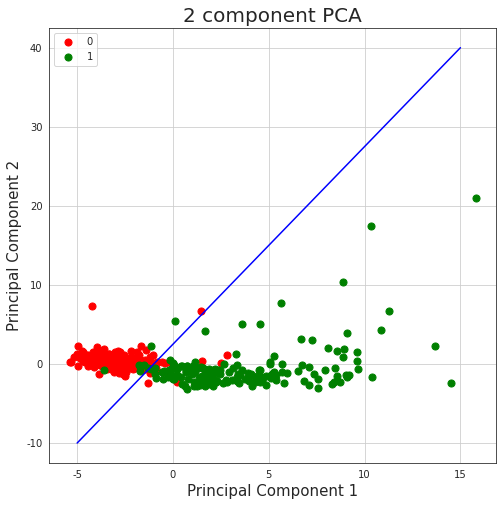

In [18]:
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('2 component PCA', fontsize = 20)
targets = [0,1]
colors = ['r', 'g', 'b']
for target, color in zip(targets,colors):
    indicesToKeep = finalDf[0] == target
    ax.scatter(finalDf.loc[indicesToKeep, 'principal component 1']
               , finalDf.loc[indicesToKeep, 'principal component 2']
               , c = color
               , s = 50)
ax.legend(targets)
ax.plot([-5,15],[-10,40], c='blue')
ax.grid()

### Przy 2 składowych głównych mamy niemal liniowo separowalne dane
dopasowana z palca prosta: y=2.5x+2.5 ma wyniki:

In [19]:
simple_prediction = []
for i in range(375):
    simple_prediction.append(int(finalDf.iloc[i,1]<(2.5 * finalDf.iloc[i,0] + 2.5)))

In [20]:
print(metrics.classification_report(finalDf.iloc[:,2], simple_prediction))

              precision    recall  f1-score   support

           0       0.96      0.94      0.95       201
           1       0.93      0.95      0.94       174

    accuracy                           0.94       375
   macro avg       0.94      0.94      0.94       375
weighted avg       0.94      0.94      0.94       375



In [21]:
pca.explained_variance_ratio_

array([0.2260109 , 0.06327361])

In [22]:
print("Explained Variance ratio with 2 components: {}, sum: {}".format(pca.explained_variance_ratio_, np.sum(pca.explained_variance_ratio_)))

Explained Variance ratio with 2 components: [0.2260109  0.06327361], sum: 0.2892845017176983


In [23]:
comp = pd.DataFrame(pca.components_,columns=df.columns[0:76],index = ['PC-1','PC-2'])
print(pd.DataFrame(pca.components_,columns=df.columns[0:76],index = ['PC-1','PC-2']))

           age    gender  Hypersensitive cardiac troponinI  hemoglobin  \
PC-1  0.125621 -0.068875                          0.074170   -0.052202   
PC-2 -0.088835  0.024048                         -0.022629   -0.090356   

      Serum chloride  Prothrombin time  procalcitonin  eosinophils(%)  \
PC-1        0.109793          0.152769       0.078577       -0.120115   
PC-2       -0.021131          0.004125      -0.052343        0.101373   

      Interleukin 2 receptor  Alkaline phosphatase  ...  \
PC-1                0.156136              0.122204  ...   
PC-2                0.033123             -0.030530  ...   

      mean corpuscular hemoglobin   Activation of partial thromboplastin time  \
PC-1                      0.058297                                   0.104781   
PC-2                      0.123109                                   0.053181   

      High sensitivity C-reactive protein  HIV antibody quantification  \
PC-1                             0.158641                    

In [24]:
np.sort(abs(comp.iloc[0,:]))

array([0.        , 0.00130004, 0.00501832, 0.00755282, 0.00970361,
       0.01459507, 0.01633861, 0.01721752, 0.02408378, 0.03057238,
       0.03362352, 0.03395047, 0.04273631, 0.0431204 , 0.04362498,
       0.05220167, 0.05594146, 0.0582967 , 0.06188574, 0.06380997,
       0.06608781, 0.06616511, 0.06716662, 0.06819616, 0.06887534,
       0.0741699 , 0.07471846, 0.07568948, 0.07857682, 0.0790868 ,
       0.07988958, 0.08445968, 0.08937828, 0.10214633, 0.10341236,
       0.10478113, 0.10601143, 0.10979272, 0.11031965, 0.11143835,
       0.11385729, 0.11769092, 0.11933167, 0.12011503, 0.12071418,
       0.12147431, 0.12220433, 0.12231569, 0.12371878, 0.12383534,
       0.12562108, 0.12994014, 0.13012988, 0.13385644, 0.13929504,
       0.14762096, 0.1499092 , 0.15276931, 0.15392194, 0.15613648,
       0.15793904, 0.15826114, 0.1586409 , 0.16060725, 0.16176967,
       0.16202476, 0.16554402, 0.16651592, 0.17046126, 0.1722937 ,
       0.17423499, 0.17679124, 0.18171541, 0.18241482, 0.18881

In [25]:
vals = (abs(comp.iloc[0,:]))>0.15
comp.iloc[0, vals.values]

Prothrombin time                       0.152769
Interleukin 2 receptor                 0.156136
albumin                               -0.182415
Platelet count                        -0.172294
neutrophils(%)                         0.176791
Prothrombin activity                  -0.200919
Urea                                   0.181715
neutrophils count                      0.162025
Mean platelet volume                   0.158261
(%)lymphocyte                         -0.174235
D-D dimer                              0.170461
HCO3-                                 -0.153922
calcium                               -0.160607
Lactate dehydrogenase                  0.188817
platelet large cell ratio              0.157939
Fibrin degradation products            0.165544
High sensitivity C-reactive protein    0.158641
thrombocytocrit                       -0.161770
eGFR                                  -0.166516
Name: PC-1, dtype: float64

In [26]:
abs(comp.iloc[0,:]).values

array([0.12562108, 0.06887534, 0.0741699 , 0.05220167, 0.10979272,
       0.15276931, 0.07857682, 0.12011503, 0.15613648, 0.12220433,
       0.18241482, 0.07988958, 0.08445968, 0.11933167, 0.1722937 ,
       0.12994014, 0.13385644, 0.06616511, 0.07471846, 0.13012988,
       0.17679124, 0.12371878, 0.00755282, 0.20091903, 0.06716662,
       0.08937828, 0.0431204 , 0.00130004, 0.12147431, 0.01459507,
       0.06380997, 0.04362498, 0.18171541, 0.06608781, 0.01633861,
       0.00501832, 0.10214633, 0.03395047, 0.07568948, 0.11385729,
       0.16202476, 0.12231569, 0.15826114, 0.12383534, 0.14762096,
       0.06188574, 0.17423499, 0.04273631, 0.17046126, 0.11769092,
       0.11143835, 0.10341236, 0.15392194, 0.16060725, 0.12071418,
       0.18881668, 0.15793904, 0.0790868 , 0.16554402, 0.01721752,
       0.1499092 , 0.03057238, 0.05594146, 0.13929504, 0.02408378,
       0.        , 0.0582967 , 0.10478113, 0.1586409 , 0.00970361,
       0.11031965, 0.16176967, 0.03362352, 0.06819616, 0.16651

In [27]:
comp.iloc[0, np.argsort(abs(comp.iloc[0,:]))].iloc[66:77]

Fibrin degradation products    0.165544
eGFR                          -0.166516
D-D dimer                      0.170461
Platelet count                -0.172294
(%)lymphocyte                 -0.174235
neutrophils(%)                 0.176791
Urea                           0.181715
albumin                       -0.182415
Lactate dehydrogenase          0.188817
Prothrombin activity          -0.200919
Name: PC-1, dtype: float64

### Powyżej najważniejsze zmienne, część się pokrywa z tymi co w artykuje, ale np. wieku nie ma

### Poniżej model dla kolumn z nowych danych

In [28]:
new_data = pd.read_csv('data/Yan_reply_First_last_wtime.csv')

In [29]:
x = new_data.iloc[:,2:8]
y = new_data.iloc[:,1]

In [30]:
new_data

,ClientVisitGUID,Expired_Outcome,Last_LDH,Last_CRP,Last_Lymph,First_LDH,First_CRP,First_Lymph,Last_time_LDH,Last_time_CRP,Last_time_Lymph,First_time_LDH,First_time_CRP,First_time_Lymph
0,1298314042,1,641,57.5,4.5,598,54.30,4.5,2 days 11:12:59,0 days 05:24:53,1 days 21:43:56,2 days 15:51:00,2 days 15:49:10,1 days 21:43:57
1,231729013,1,334,100.4,0.9,334,223.60,0.9,4 days 23:49:43,2 days 23:51:48,6 days 17:33:16,4 days 23:49:43,4 days 22:42:30,35 days 22:23:14
2,292613519,1,742,168.2,2.8,525,16.77,8.1,0 days 03:04:19,0 days 03:04:10,-1 days +23:56:08,14 days 15:58:27,15 days 18:47:49,11 days 00:51:43
3,1624500118,1,613,19.3,0.9,296,19.30,22.1,0 days 08:42:44,2 days 14:31:34,0 days 10:37:16,5 days 00:35:01,2 days 14:31:34,24 days 22:08:05
4,1101470227,1,271,25.1,2.6,374,46.70,5.4,0 days 23:21:10,-1 days +22:54:57,-1 days +20:35:07,24 days 13:05:59,24 days 13:28:36,27 days 01:15:44
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1033,1945213968,0,301,4.1,8.0,301,126.20,8.0,2 days 05:49:41,2 days 05:54:13,8 days 12:17:24,2 days 05:49:41,8 days 13:37:45,8 days 12:17:24
1034,1468702548,0,1126,69.6,14.2,1126,61.50,15.2,6 days 04:13:47,1 days 06:23:51,2 days 03:52:03,6 days 04:13:47,5 days 23:30:30,6 days 02:58:05
1035,689678610,1,340,39.5,6.1,340,39.50,6.1,1 days 01:07:35,1 days 01:07:35,1 days 06:40:15,1 days 01:07:35,1 days 01:07:35,1 days 06:40:15
1036,431248849,1,491,73.3,21.9,491,73.30,21.9,3 days 05:51:23,3 days 05:56:12,4 days 01:27:16,3 days 05:51:23,3 days 05:56:12,4 days 01:27:16


### Tutaj bez kolumn typu 6 days 17:33:16

In [31]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.pipeline import Pipeline
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.pipeline import Pipeline
from sklearn.ensemble import AdaBoostClassifier
from matplotlib import pyplot as plt
x_train, x_test, y_train, y_test = train_test_split(new_data.iloc[:,2:8], new_data.iloc[:,1], random_state=123)

clf = GradientBoostingClassifier(n_estimators=75, learning_rate=.05,
    max_depth=3, random_state=123)

clf.fit(x_train,y_train)
prediction_test=clf.predict(x_test)
print(prediction_test)
clf.score(x_test,y_test)

[0 1 0 0 0 1 0 0 1 0 1 1 0 0 0 0 0 1 1 0 1 0 1 0 0 0 0 1 1 0 0 1 0 0 0 0 1
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 1 0 0 0 0 0 0 1 0 1 0 0 1 0 0 0 0
 0 0 0 1 1 0 0 0 1 1 0 1 0 0 0 1 0 1 0 0 0 0 0 1 0 1 1 1 1 0 0 1 0 0 0 1 0
 0 0 0 0 1 0 1 0 0 1 0 1 0 0 1 0 0 0 1 1 0 0 1 0 0 0 0 1 0 0 0 1 1 0 0 0 0
 0 0 0 1 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 1 1 1 0 0 1 1 0 1 0 0 0 0 0 0 0 1 0
 0 0 1 1 0 0 0 0 1 0 1 0 0 0 1 0 0 0 0 0 0 0 0 0 1 0 1 0 0 0 0 0 0 0 0 0 1
 0 0 0 0 1 1 0 1 0 1 0 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0
 1]


0.8

### A tutaj biorąc tylko dni z tych kolumn

In [32]:
def days_to_num(test_str):
    test_str = str(test_str)
    for char in test_str:
        if not char.isdigit() and char not in ['.','-']:
            temp = test_str.index(char)
            return float(str(test_str[0 : temp]))
    return float(test_str)
def df_change_date(data):
    features = ['Last_time_LDH', 'Last_time_CRP', 'Last_time_Lymph', 
                'First_time_LDH', 'First_time_CRP', 'First_time_Lymph']
    for feature in features:
        data[feature] = data[feature].apply(days_to_num)
    return data

In [33]:
df_change_date(new_data)

,ClientVisitGUID,Expired_Outcome,Last_LDH,Last_CRP,Last_Lymph,First_LDH,First_CRP,First_Lymph,Last_time_LDH,Last_time_CRP,Last_time_Lymph,First_time_LDH,First_time_CRP,First_time_Lymph
0,1298314042,1,641,57.5,4.5,598,54.30,4.5,2.0,0.0,1.0,2.0,2.0,1.0
1,231729013,1,334,100.4,0.9,334,223.60,0.9,4.0,2.0,6.0,4.0,4.0,35.0
2,292613519,1,742,168.2,2.8,525,16.77,8.1,0.0,0.0,-1.0,14.0,15.0,11.0
3,1624500118,1,613,19.3,0.9,296,19.30,22.1,0.0,2.0,0.0,5.0,2.0,24.0
4,1101470227,1,271,25.1,2.6,374,46.70,5.4,0.0,-1.0,-1.0,24.0,24.0,27.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1033,1945213968,0,301,4.1,8.0,301,126.20,8.0,2.0,2.0,8.0,2.0,8.0,8.0
1034,1468702548,0,1126,69.6,14.2,1126,61.50,15.2,6.0,1.0,2.0,6.0,5.0,6.0
1035,689678610,1,340,39.5,6.1,340,39.50,6.1,1.0,1.0,1.0,1.0,1.0,1.0
1036,431248849,1,491,73.3,21.9,491,73.30,21.9,3.0,3.0,4.0,3.0,3.0,4.0


In [34]:
x_train2, x_test2, y_train2, y_test2 = train_test_split(new_data.iloc[:,2:14], new_data.iloc[:,1], random_state=123)

clf = GradientBoostingClassifier(n_estimators=75, learning_rate=.05,
    max_depth=3, random_state=123)


clf.fit(x_train2,y_train2)
prediction_test2=clf.predict(x_test2)
print(prediction_test2)
clf.score(x_test2,y_test2)

[0 1 0 0 0 1 0 0 1 0 1 1 0 0 0 0 0 1 1 0 0 0 1 0 0 1 0 1 0 0 0 1 0 0 0 0 0
 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 1 0 0 0 1 0 0 0 0 0 0 1 0 1 0 0 1 0 0 0 0
 0 0 0 1 0 0 0 0 1 1 1 1 0 0 0 1 0 0 0 0 0 0 0 1 0 1 1 1 0 0 0 1 0 1 0 1 1
 0 0 0 0 1 0 1 0 0 1 0 1 0 0 1 0 0 0 1 1 0 0 1 0 1 0 1 0 0 0 0 1 0 0 0 0 0
 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 1 1 1 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 1 0 0 0 0 0 0 1 0 0 0 1 0 0 0 0 0 1 0 0 0 1 0 1 0 0 0 0 0 0 0 0 0 1
 0 0 0 0 1 1 0 1 1 1 0 0 1 0 1 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0
 1]


0.8615384615384616

In [35]:
print(metrics.classification_report(y_test2, prediction_test2))

              precision    recall  f1-score   support

           0       0.86      0.95      0.90       175
           1       0.87      0.68      0.76        85

    accuracy                           0.86       260
   macro avg       0.86      0.82      0.83       260
weighted avg       0.86      0.86      0.86       260



Accuracy skoczyło z 0.8 do 0.86

In [36]:
from sklearn.model_selection import cross_validate
print('Kroswalidacja dla GradientBoosting')
print(np.mean(cross_validate(clf, x_test2, y_test2, cv=20, scoring='accuracy').get('test_score')))

Kroswalidacja dla GradientBoosting
0.8307692307692308


### Adaboost

In [37]:
clf1 = AdaBoostClassifier(random_state=1,learning_rate=0.15,algorithm ='SAMME.R')
clf1.fit(x_train2,y_train2)
prediction_test_ada=clf1.predict(x_test2)
print(prediction_test_ada)
clf1.score(x_test2,y_test2)

[0 1 0 0 0 1 0 0 1 0 1 1 0 0 0 0 0 1 1 0 1 0 1 0 0 1 0 1 0 0 0 1 0 0 0 0 0
 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 1 0 0 0 1 0 0 0 0 0 0 1 0 1 0 0 1 0 0 0 0
 0 0 0 1 0 0 0 0 1 1 0 1 0 0 0 1 0 1 0 0 0 0 0 1 0 1 1 1 1 0 0 1 0 0 0 1 1
 0 0 0 0 1 0 1 1 1 1 0 0 0 0 1 0 0 0 1 1 0 0 1 0 1 1 1 0 0 0 0 1 0 0 0 0 0
 0 0 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 0 0 1 1 0 1 1 0 0 0 0 0 0 0 0
 0 0 0 1 0 0 0 0 0 0 1 0 0 0 1 0 0 0 0 0 1 0 0 0 1 0 1 0 0 0 0 0 0 0 0 0 1
 0 0 0 0 1 1 0 1 0 1 0 0 1 0 1 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0
 1]


0.8384615384615385

In [38]:
from sklearn.model_selection import cross_validate
print('Kroswalidacja dla AdaBoosting')
print(np.mean(cross_validate(clf1, x_test2, y_test2, cv=30, scoring='accuracy').get('test_score')))

Kroswalidacja dla AdaBoosting
0.8430555555555554


### histogramy zmiennych

In [39]:
new_data

,ClientVisitGUID,Expired_Outcome,Last_LDH,Last_CRP,Last_Lymph,First_LDH,First_CRP,First_Lymph,Last_time_LDH,Last_time_CRP,Last_time_Lymph,First_time_LDH,First_time_CRP,First_time_Lymph
0,1298314042,1,641,57.5,4.5,598,54.30,4.5,2.0,0.0,1.0,2.0,2.0,1.0
1,231729013,1,334,100.4,0.9,334,223.60,0.9,4.0,2.0,6.0,4.0,4.0,35.0
2,292613519,1,742,168.2,2.8,525,16.77,8.1,0.0,0.0,-1.0,14.0,15.0,11.0
3,1624500118,1,613,19.3,0.9,296,19.30,22.1,0.0,2.0,0.0,5.0,2.0,24.0
4,1101470227,1,271,25.1,2.6,374,46.70,5.4,0.0,-1.0,-1.0,24.0,24.0,27.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1033,1945213968,0,301,4.1,8.0,301,126.20,8.0,2.0,2.0,8.0,2.0,8.0,8.0
1034,1468702548,0,1126,69.6,14.2,1126,61.50,15.2,6.0,1.0,2.0,6.0,5.0,6.0
1035,689678610,1,340,39.5,6.1,340,39.50,6.1,1.0,1.0,1.0,1.0,1.0,1.0
1036,431248849,1,491,73.3,21.9,491,73.30,21.9,3.0,3.0,4.0,3.0,3.0,4.0


findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


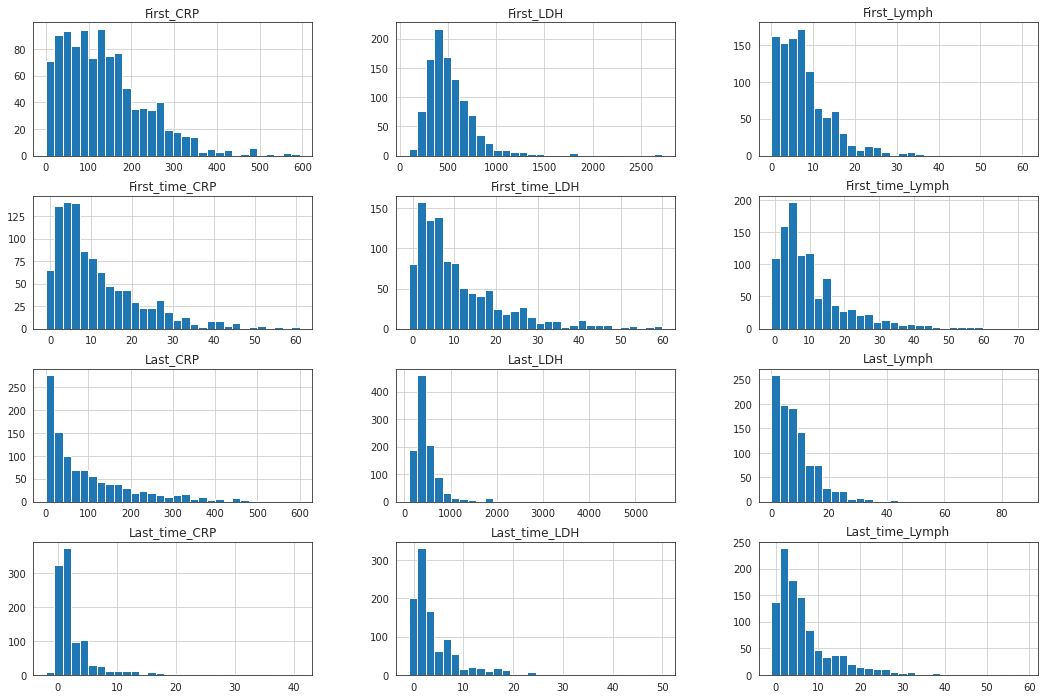

In [41]:
new_data[new_data.columns.tolist()[2:]].hist(figsize=(18, 12), bins=30)
plt.show()

In [42]:
def sqrt_data(data = new_data, features=new_data.columns.tolist()[2:]):
    for feature in features:
        data[feature] = np.sqrt(np.abs(data[feature])) * np.sign(data[feature]) 
    return data

In [43]:
sqrt_data()

,ClientVisitGUID,Expired_Outcome,Last_LDH,Last_CRP,Last_Lymph,First_LDH,First_CRP,First_Lymph,Last_time_LDH,Last_time_CRP,Last_time_Lymph,First_time_LDH,First_time_CRP,First_time_Lymph
0,1298314042,1,25.317978,7.582875,2.121320,24.454039,7.368853,2.121320,1.414214,0.000000,1.000000,1.414214,1.414214,1.000000
1,231729013,1,18.275667,10.019980,0.948683,18.275667,14.953261,0.948683,2.000000,1.414214,2.449490,2.000000,2.000000,5.916080
2,292613519,1,27.239677,12.969194,1.673320,22.912878,4.095119,2.846050,0.000000,0.000000,-1.000000,3.741657,3.872983,3.316625
3,1624500118,1,24.758837,4.393177,0.948683,17.204651,4.393177,4.701064,0.000000,1.414214,0.000000,2.236068,1.414214,4.898979
4,1101470227,1,16.462078,5.009990,1.612452,19.339080,6.833740,2.323790,0.000000,-1.000000,-1.000000,4.898979,4.898979,5.196152
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1033,1945213968,0,17.349352,2.024846,2.828427,17.349352,11.233877,2.828427,1.414214,1.414214,2.828427,1.414214,2.828427,2.828427
1034,1468702548,0,33.555923,8.342661,3.768289,33.555923,7.842194,3.898718,2.449490,1.000000,1.414214,2.449490,2.236068,2.449490
1035,689678610,1,18.439089,6.284903,2.469818,18.439089,6.284903,2.469818,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
1036,431248849,1,22.158520,8.561542,4.679744,22.158520,8.561542,4.679744,1.732051,1.732051,2.000000,1.732051,1.732051,2.000000


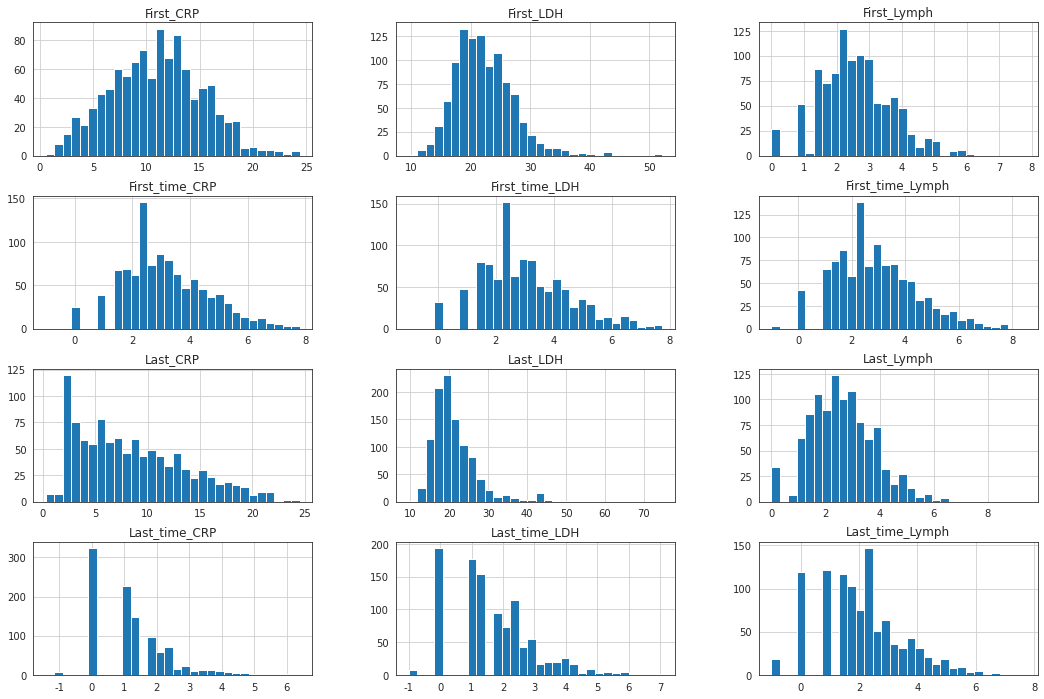

In [44]:
new_data[new_data.columns.tolist()[2:]].hist(figsize=(18, 12), bins=30)
plt.show()

In [45]:
x_train_s, x_test_s, y_train_s, y_test_s = train_test_split(new_data.iloc[:,2:14], new_data.iloc[:,1], random_state=123)

clf_s = AdaBoostClassifier(random_state=123,learning_rate=0.15,algorithm ='SAMME.R')

clf_s.fit(x_train_s,y_train_s)
prediction_test_s=clf.predict(x_test_s)
print(prediction_test_s)
clf.score(x_test_s,y_test_s)

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0]


0.676923076923077

In [46]:
print("Wyniki z pierwiastkowanymi danymi:")
print(metrics.classification_report(y_test_s, prediction_test_s))

Wyniki z pierwiastkowanymi danymi:
              precision    recall  f1-score   support

           0       0.68      1.00      0.81       175
           1       1.00      0.01      0.02        85

    accuracy                           0.68       260
   macro avg       0.84      0.51      0.41       260
weighted avg       0.78      0.68      0.55       260



In [47]:
print('Wyniki przed pierwiastkowaniem danych:')
print(metrics.classification_report(y_test2, prediction_test2))

Wyniki przed pierwiastkowaniem danych:
              precision    recall  f1-score   support

           0       0.86      0.95      0.90       175
           1       0.87      0.68      0.76        85

    accuracy                           0.86       260
   macro avg       0.86      0.82      0.83       260
weighted avg       0.86      0.86      0.86       260

